In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_score
import zipfile, StringIO, requests
stemmer = SnowballStemmer('english')
import matplotlib.pyplot as plt
%matplotlib inline

## Open files  all file inside ../data/ folder and in zip format

In [2]:
z = zipfile.ZipFile('../data/train.csv.zip')
df_train = pd.read_csv(z.open('train.csv'), encoding="ISO-8859-1")
z2 = zipfile.ZipFile('../data/attributes.csv.zip')
df_attributes = pd.read_csv(z2.open('attributes.csv'))
z3 = zipfile.ZipFile('../data/product_descriptions.csv.zip')
df_pro_desc = pd.read_csv(z3.open('product_descriptions.csv'))
z4 = zipfile.ZipFile('../data/test.csv.zip')
df_test = pd.read_csv(z4.open('test.csv'), encoding="ISO-8859-1")

In [3]:
len(df_train.product_uid.unique())/float(len(df_train))

0.7380749861611784

In [4]:
num_train = df_train.shape[0]
num_train

74067

In [5]:
def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

## Data cleaning

In [6]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))


## Feature Creation

In [7]:
df_all['matched_words'] = df_all['word_in_title'] + df_all['word_in_description']
df_all['search_ratio'] = (df_all['word_in_title'] + df_all['word_in_description']) / df_all['len_of_query']
df_all['title_ratio'] = (df_all['word_in_title']) / df_all['len_of_query']
df_all['desc_ratio'] = (df_all['word_in_description']) / df_all['len_of_query']

In [8]:
df_all.head()

,id,product_title,product_uid,relevance,search_term,product_description,len_of_query,product_info,word_in_title,word_in_description,matched_words,search_ratio,title_ratio,desc_ratio
0,2,simpson strong-ti 12-gaug angl,100001,3.00,angl bracket,"not onli do angl make joint stronger, they als...",2,angl bracket\tsimpson strong-ti 12-gaug angl\t...,1,1,2,1.000000,0.500000,0.500000
1,3,simpson strong-ti 12-gaug angl,100001,2.50,l bracket,"not onli do angl make joint stronger, they als...",2,l bracket\tsimpson strong-ti 12-gaug angl\tnot...,1,1,2,1.000000,0.500000,0.500000
2,9,behr premium textur deckov 1-gal. #sc-141 tugb...,100002,3.00,deck over,behr premium textur deckov is an innov solid c...,2,deck over\tbehr premium textur deckov 1-gal. #...,1,1,2,1.000000,0.500000,0.500000
3,16,delta vero 1-handl shower onli faucet trim kit...,100005,2.33,rain shower head,updat your bathroom with the delta vero single...,3,rain shower head\tdelta vero 1-handl shower on...,1,1,2,0.666667,0.333333,0.333333
4,17,delta vero 1-handl shower onli faucet trim kit...,100005,2.67,shower onli faucet,updat your bathroom with the delta vero single...,3,shower onli faucet\tdelta vero 1-handl shower ...,3,2,5,1.666667,1.000000,0.666667


In [9]:
df_all.drop(['word_in_description'],axis=1, inplace=True)

In [10]:
df_all2 = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

In [11]:
df_all2.head()

,id,product_uid,relevance,len_of_query,word_in_title,matched_words,search_ratio,title_ratio,desc_ratio
0,2,100001,3.00,2,1,2,1.000000,0.500000,0.500000
1,3,100001,2.50,2,1,2,1.000000,0.500000,0.500000
2,9,100002,3.00,2,1,2,1.000000,0.500000,0.500000
3,16,100005,2.33,3,1,2,0.666667,0.333333,0.333333
4,17,100005,2.67,3,3,5,1.666667,1.000000,0.666667


In [12]:
df_train = df_all2.iloc[:num_train]
df_test = df_all2.iloc[num_train:]
id_test = df_test['id']

In [13]:
df_train.head()

,id,product_uid,relevance,len_of_query,word_in_title,matched_words,search_ratio,title_ratio,desc_ratio
0,2,100001,3.00,2,1,2,1.000000,0.500000,0.500000
1,3,100001,2.50,2,1,2,1.000000,0.500000,0.500000
2,9,100002,3.00,2,1,2,1.000000,0.500000,0.500000
3,16,100005,2.33,3,1,2,0.666667,0.333333,0.333333
4,17,100005,2.67,3,3,5,1.666667,1.000000,0.666667


## Machine Learning

In [52]:
y = df_train['relevance'].values
X = df_train.drop(['id','relevance','product_uid'],axis=1).values
X_df = df_train.drop(['id','relevance','product_uid'],axis=1)
X_test = df_test.drop(['id','relevance','product_uid'],axis=1).values

In [53]:
X[:2]

array([[ 2. ,  1. ,  2. ,  1. ,  0.5,  0.5],
       [ 2. ,  1. ,  2. ,  1. ,  0.5,  0.5]])

In [54]:
rf = RandomForestRegressor(n_estimators=40, n_jobs=-1)
bag = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)

In [55]:
rf.fit(X, y)
bag.fit(X, y)

BaggingRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.1, n_estimators=45, n_jobs=1, oob_score=False,
         random_state=25, verbose=0, warm_start=False)

In [56]:
print 'Random Forest RMSE :', mean_squared_error(y, rf.predict(X))**0.5

Random Forest RMSE : 0.484334151764


In [57]:
print 'RMSE :', mean_squared_error(y, bag.predict(X))**0.5

RMSE : 0.484638024542


In [58]:
feat_rank = np.argsort(rf.feature_importances_)[::-1]
feat_rank

array([4, 3, 2, 5, 0, 1])

In [59]:
X_df.columns[feat_rank][:25]

Index([u'title_ratio', u'search_ratio', u'matched_words', u'desc_ratio',
       u'len_of_query', u'word_in_title'],
      dtype='object')

In [60]:
df_features = pd.DataFrame(rf.feature_importances_,X_df.columns, columns = ['feature_value'])
df_features.sort_values('feature_value', ascending=False)

,feature_value
title_ratio,0.641455
search_ratio,0.227706
matched_words,0.057788
desc_ratio,0.030671
len_of_query,0.029603
word_in_title,0.012778


In [61]:
scores = np.zeros((feat_rank.shape[0],2))
for i in range(1,feat_rank.shape[0]+1):
    features = [X_df.columns[feat_rank][x] for x in range(i)]
    scores[i-1:] = (i,(cross_val_score(rf, X_df[features], df_train['relevance'], cv=3)).mean())
scores    

array([[ 1.        ,  0.09499685],
       [ 2.        ,  0.11891691],
       [ 3.        ,  0.13609489],
       [ 4.        ,  0.13629551],
       [ 5.        ,  0.13698022],
       [ 6.        ,  0.13689495]])

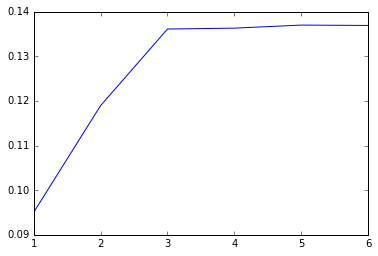

In [62]:
plt.plot(scores[:,:1],scores[:,1:2])

In [65]:
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# build a classifier
rf = RandomForestRegressor()

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [ ]:
# specify parameters and distributions to sample from
param_grid = {'max_depth': [50, 100, None],
              'max_features': ['sqrt', 'log2', None],
              'min_samples_split': [1, 4, 8, 10, 12],
              'min_samples_leaf': [8, 12, 16, 20],
              'bootstrap': [True, False],
              'n_estimators': [40, 60, 80, 100]}

# run grid search
print ('Starting Grid Search.')
grid_search = GridSearchCV(rf, param_grid=param_grid, n_jobs=-1, scoring='mean_squared_error')
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

Starting Grid Search.


In [67]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [68]:
y_pred

array([ 2.07968786,  2.15554347,  2.15554347, ...,  2.49412136,
        2.67792363,  2.34427998])

In [69]:
pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('../submissions/homedepot-submission.csv',index=False)